# **Ujian Akhir Semester - Pengolahan Bahasa Alami**

## Anggota Kelompok:
- **Kevin Philips Tanamas** (220711789)  
- **Richard Angelico** (220711747)
- **Anthony Alvin Nathaniel** (220711773)
- **Nicholas Raymond Thosimaru** (220712111)
- **Maria** (220711969)

## Library Import

In [1]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import gc
import fasttext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from seqeval.scheme import BILOU
from seqeval.metrics import classification_report, f1_score

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, GRU, Dense, TimeDistributed, Dropout
from collections import Counter
from sklearn.model_selection import train_test_split

tqdm.pandas()

2025-06-26 14:09:14.492038: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-26 14:09:14.521210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750921754.561532 1052559 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750921754.569157 1052559 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-26 14:09:14.606344: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Data Loading Function

## Load Data

In [3]:
def insert_blank_lines(input_path, output_path):
    with open(input_path, 'r', encoding='utf-8') as infile, open(output_path, 'w', encoding='utf-8') as outfile:
        for line in infile:
            outfile.write(line)
            if line.strip().endswith(('.-O', '!-O', '?-O')):
                outfile.write('\n') 

insert_blank_lines("dataset_betawi.txt", "dataset_betawi_split.txt")

In [4]:
def load_data(file_path):
    sentences = []
    labels = []
    sentence = []
    label_seq = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                # Baris kosong = akhir kalimat
                if sentence:
                    sentences.append(sentence)
                    labels.append(label_seq)
                    sentence = []
                    label_seq = []
                continue

            # Hapus nomor dan titik dua di depan (contoh: "12: Ane-O")
            if ":" in line:
                line = line.split(":", 1)[1].strip()

            if "-" not in line:
                continue

            token, tag = line.rsplit("-", 1)
            sentence.append(token)
            label_seq.append(tag)

        # Tambahkan kalimat terakhir jika ada
        if sentence:
            sentences.append(sentence)
            labels.append(label_seq)

    return sentences, labels

In [5]:
with open("./dataset_betawi_split.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

for i, line in enumerate(lines[:20]):
    print(f"{i+1}: {line.strip()}")


1: Ane-O
2: pake-O
3: Honda-B-PRODUCT
4: Jazz-I-PRODUCT
5: GK5-I-PRODUCT
6: 2014-L-PRODUCT
7: (-O
8: pertama-O
9: diluncurkan-O
10: )-O
11: .-O
12: 
13: Mobilnya-B-OTHERS_POSITIVE
14: bagus-I-OTHERS_POSITIVE
15: dan-I-OTHERS_POSITIVE
16: bagus-I-OTHERS_POSITIVE
17: sesuai-I-OTHERS_POSITIVE
18: motto-I-OTHERS_POSITIVE
19: ,-I-OTHERS_POSITIVE
20: asik-I-OTHERS_POSITIVE


In [6]:
# Load all data
full_file = "./dataset_betawi_split.txt"
sentences, labels = load_data(full_file)

# Check if data loaded
print(f"Loaded {len(sentences)} samples.")

# Split into train (70%) and temp (30%)
train_sentences, temp_sentences, train_labels, temp_labels = train_test_split(
    sentences, labels, test_size=0.3, random_state=42
)

# Split temp into validation (15%) and test (15%)
valid_sentences, test_sentences, valid_labels, test_labels = train_test_split(
    temp_sentences, temp_labels, test_size=0.5, random_state=42
)

# Create dataframes
train_df = pd.DataFrame({'tokens': train_sentences, 'tags': train_labels})
valid_df = pd.DataFrame({'tokens': valid_sentences, 'tags': valid_labels})
test_df = pd.DataFrame({'tokens': test_sentences, 'tags': test_labels})
df_all = pd.DataFrame({'tokens': sentences, 'tags': labels})

# Informasi tentang kolom
print("\nInformasi kolom DataFrame:")
print(df_all.dtypes)

# Deskripsi singkat isi data
lengths = [len(s) for s in sentences]
print("\nDeskripsi data:")
print(f"Total kalimat: {len(sentences)}")
print(f"Rata-rata panjang kalimat: {sum(lengths)/len(lengths):.2f} tokens")
print(f"Kalimat terpendek: {min(lengths)} tokens")
print(f"Kalimat terpanjang: {max(lengths)} tokens")

# Print sizes
print(f"Train: {len(train_df)}, Valid: {len(valid_df)}, Test: {len(test_df)}")

Loaded 867 samples.

Informasi kolom DataFrame:
tokens    object
tags      object
dtype: object

Deskripsi data:
Total kalimat: 867
Rata-rata panjang kalimat: 18.45 tokens
Kalimat terpendek: 1 tokens
Kalimat terpanjang: 124 tokens
Train: 606, Valid: 130, Test: 131


## Data Checking (Liat Semua Tags) & Visualization

In [7]:
# Set all tags (flattened) from training labels
all_tags_flat = [tag for seq in train_labels for tag in seq]

print(f"Total tags in training: {len(all_tags_flat)}")

print("Tag distribution in training set:")
tag_counts = pd.Series(all_tags_flat).value_counts()
print(tag_counts.head(10))

Total tags in training: 11221
Tag distribution in training set:
O                   6845
PRODUCT             1093
OTHERS_POSITIVE      697
MACHINE_POSITIVE     471
PART_POSITIVE        441
PART_NEGATIVE        310
FUEL_POSITIVE        306
PRICE_POSITIVE       227
SERVICE_POSITIVE     214
SERVICE_NEGATIVE     193
Name: count, dtype: int64


C:\Users\Pongo\AppData\Local\Temp\ipykernel_21608\2071062896.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.values, y=tag_counts.index, palette="viridis")


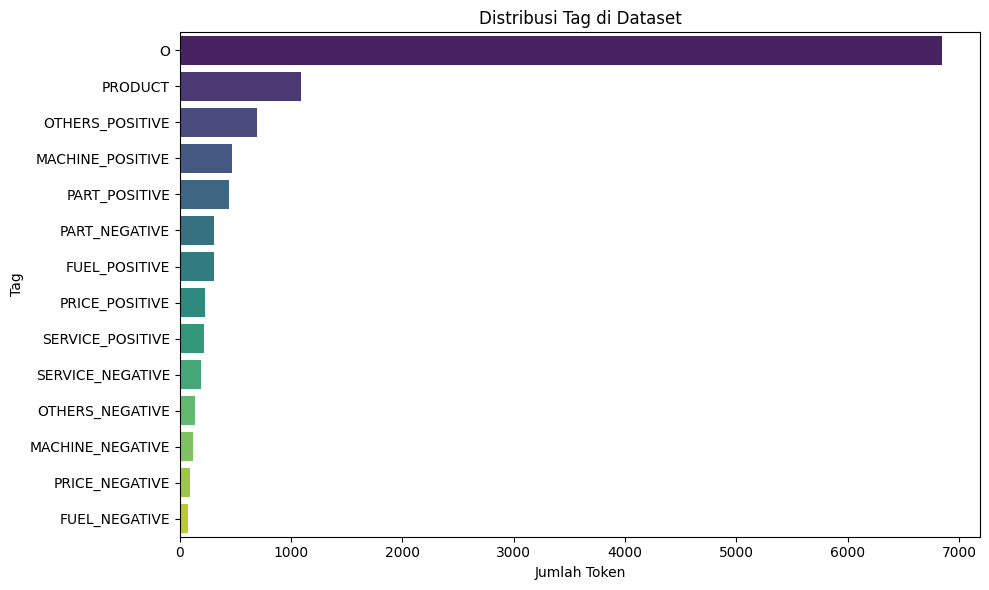

In [141]:
plt.figure(figsize=(10, 6))
sns.barplot(x=tag_counts.values, y=tag_counts.index, palette="viridis")
plt.title("Distribusi Tag di Dataset")
plt.xlabel("Jumlah Token")
plt.ylabel("Tag")
plt.tight_layout()
plt.show()

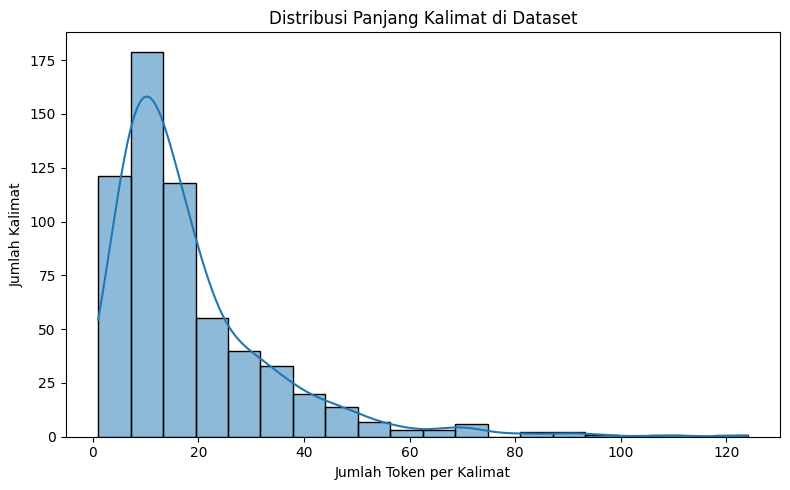

In [142]:
train_lengths = [len(seq) for seq in train_sentences]

plt.figure(figsize=(8, 5))
sns.histplot(train_lengths, bins=20, kde=True)
plt.title("Distribusi Panjang Kalimat di Dataset")
plt.xlabel("Jumlah Token per Kalimat")
plt.ylabel("Jumlah Kalimat")
plt.tight_layout()
plt.show()

C:\Users\Pongo\AppData\Local\Temp\ipykernel_21608\2212785168.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=common_tokens.values, y=common_tokens.index, palette="mako")


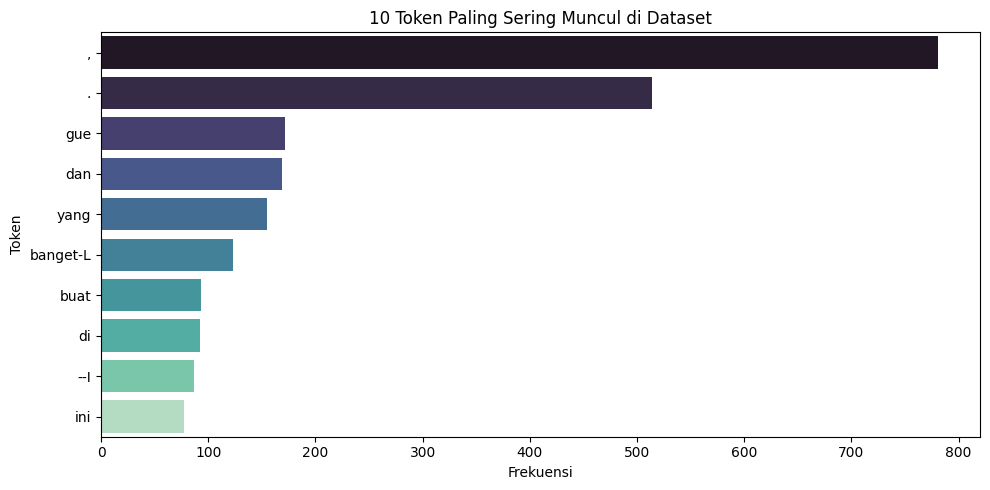

In [143]:
all_tokens = [tok for seq in train_sentences for tok in seq]
token_counts = Counter(all_tokens)
common_tokens = pd.Series(dict(token_counts.most_common(10)))

plt.figure(figsize=(10, 5))
sns.barplot(x=common_tokens.values, y=common_tokens.index, palette="mako")
plt.title("10 Token Paling Sering Muncul di Dataset")
plt.xlabel("Frekuensi")
plt.ylabel("Token")
plt.tight_layout()
plt.show()


C:\Users\Pongo\AppData\Local\Temp\ipykernel_21608\1962913272.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=split_counts.index, y=split_counts.values, palette="deep")


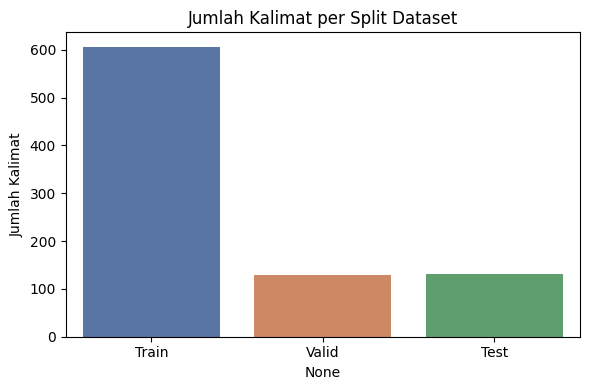

In [144]:
split_counts = pd.Series({
    "Train": len(train_df),
    "Valid": len(valid_df),
    "Test": len(test_df)
})

plt.figure(figsize=(6, 4))
sns.barplot(x=split_counts.index, y=split_counts.values, palette="deep")
plt.title("Jumlah Kalimat per Split Dataset")
plt.ylabel("Jumlah Kalimat")
plt.tight_layout()
plt.show()

## Load FastText Model

In [145]:
# Cek dan unduh FastText model jika belum tersedia
if not os.path.exists('./cc.id.300.bin'):
    print("FastText model not found. Downloading model (this may take a while)...")
    os.system("wget -c https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz")
    os.system("gunzip cc.id.300.bin.gz")
    print("Download complete.")

# Load FastText model
# Download file .bin https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
# Extract file .gz
# Pastikan file cc.id.300.bin ada di direktori yang sama dengan Jupyter Notebook ini
print("Loading FastText model...")
ft = fasttext.load_model('./cc.id.300.bin')
print("FastText model loaded successfully.")

# Set embedding size dan panjang maksimum urutan
emb_size = 300
max_seq_len = 128


Loading FastText model...
FastText model loaded successfully.


## Tag Mapping

In [146]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Buat mapping tag ke ID
all_tags = sorted(set(tag for seq in train_df['tags'] for tag in seq))
tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index['PAD'] = 0
index2tag = {idx: tag for tag, idx in tag2index.items()}

num_tags = len(tag2index)

# Fungsi untuk encoding dan padding label
def encode_tags(tags, tag2index, max_len):
    tag_ids = [tag2index.get(tag, tag2index['PAD']) for tag in tags]
    return pad_sequences([tag_ids], maxlen=max_len, padding='post', value=tag2index['PAD'])[0]

train_df['tag_ids'] = train_df['tags'].apply(lambda tags: encode_tags(tags, tag2index, max_seq_len))
valid_df['tag_ids'] = valid_df['tags'].apply(lambda tags: encode_tags(tags, tag2index, max_seq_len))
test_df['tag_ids'] = test_df['tags'].apply(lambda tags: encode_tags(tags, tag2index, max_seq_len))

print(f"Number of unique tags (including PAD): {num_tags}")

Number of unique tags (including PAD): 15


## Word Embeddings Function

In [147]:
# Membuat fungsi untuk menghasilkan word embeddings dari token
def get_tok_emb(tokens):
    emb = np.zeros((max_seq_len, emb_size))
    for i, word in enumerate(tokens[:max_seq_len]):
        emb[i] = ft.get_word_vector(word)
    return emb

# Proses pembuatan embeddings untuk setiap token dalam dataset
print("Creating word embeddings...")
train_df['tokens_embedding'] = train_df['tokens'].progress_apply(get_tok_emb)
valid_df['tokens_embedding'] = valid_df['tokens'].progress_apply(get_tok_emb)
test_df['tokens_embedding'] = test_df['tokens'].progress_apply(get_tok_emb)

Creating word embeddings...


100%|██████████| 131/131 [00:00<00:00, 1228.31it/s]


In [148]:
# Membuat mapping untuk tag ke indeks dan sebaliknya
print("Creating tag mapping...")

# Ambil semua tag unik dari data latih
all_tags = sorted(set(tag for seq in train_df['tags'] for tag in seq))
print(f"Number of unique tags: {len(all_tags)}")

# Buat mapping dari tag ke indeks, dengan indeks 0 untuk padding
tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index['PAD'] = 0  # PAD token at index 0

# Buat mapping sebaliknya dari indeks ke tag
index2tag = {idx: tag for tag, idx in tag2index.items()}

# Tampilkan beberapa mapping untuk verifikasi
print("Tag to index mapping (sample):")
for i, (tag, idx) in enumerate(tag2index.items()):
    if i < 10:  # Tampilkan 10 pertama
        print(f"{tag} -> {idx}")


Creating tag mapping...
Number of unique tags: 14
Tag to index mapping (sample):
FUEL_NEGATIVE -> 1
FUEL_POSITIVE -> 2
MACHINE_NEGATIVE -> 3
MACHINE_POSITIVE -> 4
O -> 5
OTHERS_NEGATIVE -> 6
OTHERS_POSITIVE -> 7
PART_NEGATIVE -> 8
PART_POSITIVE -> 9
PRICE_NEGATIVE -> 10


## Dimensionality Reduction (PCA)

In [149]:
# Gabungkan semua embedding untuk fit PCA
all_embeddings = np.vstack(train_df['tokens_embedding'].values)
pca_components = 50
pca = PCA(n_components=pca_components)
pca.fit(all_embeddings)

# Transform setiap embedding sequence
def reduce_dims(emb_matrix):
    return pca.transform(emb_matrix)

train_df['tokens_embedding_pca'] = train_df['tokens_embedding'].progress_apply(reduce_dims)
valid_df['tokens_embedding_pca'] = valid_df['tokens_embedding'].progress_apply(reduce_dims)
test_df['tokens_embedding_pca'] = test_df['tokens_embedding'].progress_apply(reduce_dims)

# Update embedding size ke dimensi baru
emb_size = pca_components

100%|██████████| 131/131 [00:00<00:00, 1619.71it/s]


## Optimasi Dataset

In [150]:
X_train = np.stack(train_df['tokens_embedding_pca'].values)
y_train = np.stack(train_df['tag_ids'].values)

X_valid = np.stack(valid_df['tokens_embedding_pca'].values)
y_valid = np.stack(valid_df['tag_ids'].values)

X_test = np.stack(test_df['tokens_embedding_pca'].values)
y_test = np.stack(test_df['tag_ids'].values)

# Expand label dims: (batch_size, timesteps, 1)
y_train = np.expand_dims(y_train, -1)
y_valid = np.expand_dims(y_valid, -1)
y_test = np.expand_dims(y_test, -1)

print("Feature engineering complete.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"X_test shape: {X_test.shape}")

Feature engineering complete.
X_train shape: (606, 128, 50)
y_train shape: (606, 128, 1)
X_valid shape: (130, 128, 50)
X_test shape: (131, 128, 50)


## Bilstm Model Function

In [151]:
def bilstm_model(max_len_seq, emb_size, rnn_units, num_tags, lr=0.001):
    """
    Bidirectional LSTM model for NER - highest accuracy but slowest training

    Args:
        max_len_seq: Maximum sequence length
        emb_size: Embedding size
        rnn_units: Number of LSTM units per direction
        num_tags: Number of output tags
        lr: Learning rate
    """
    # Input layer
    inputs = Input(shape=(max_len_seq, emb_size), dtype='float32')

    # Projection layer to reduce dimensions
    x = Dense(128, activation='relu')(inputs)

    # Bidirectional LSTM - processes sequences in both directions
    # Higher accuracy for context-dependent tasks like NER
    x = Bidirectional(
        LSTM(
            rnn_units,
            return_sequences=True,
            recurrent_dropout=0.0,
            implementation=2  # potentially faster but less stable
        )
    )(x)

    # Dropout for regularization
    x = Dropout(0.3)(x)

    # Output layer
    output = TimeDistributed(Dense(num_tags, activation='softmax'))(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


def bigru_model(max_len_seq, emb_size, rnn_units, num_tags, lr=0.001):
    """
    Bidirectional GRU model - good balance between speed and accuracy

    Args:
        max_len_seq: Maximum sequence length
        emb_size: Embedding size
        rnn_units: Number of GRU units per direction
        num_tags: Number of output tags
        lr: Learning rate
    """
    # Input layer
    inputs = Input(shape=(max_len_seq, emb_size), dtype='float32')

    # Projection layer
    x = Dense(128, activation='relu')(inputs)

    # Bidirectional GRU - faster than LSTM with similar capabilities
    x = Bidirectional(
        GRU(
            rnn_units,
            return_sequences=True,
            recurrent_dropout=0.0,
            reset_after=True  # modern GRU implementation
        )
    )(x)

    # Dropout for regularization
    x = Dropout(0.2)(x)

    # Output layer
    output = TimeDistributed(Dense(num_tags, activation='softmax'))(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [2]:
# Force CPU usage for memory-intensive operations
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU for data preparation

def simple_rnn_model(max_len_seq, emb_size, rnn_units, num_tags, lr=0.001):
    """
    SimpleRNN model for NER - fastest training, but typically lower accuracy

    Args:
        max_len_seq: Maximum sequence length
        emb_size: Embedding size
        rnn_units: Number of RNN units
        num_tags: Number of output tags
        lr: Learning rate
    """
    # Input layer
    inputs = Input(shape=(max_len_seq, emb_size), dtype='float32')

    # Optional projection to reduce dimensions
    x = Dense(128, activation='relu')(inputs)

    # SimpleRNN layer - fastest but less capable for sequence modeling
    x = tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True)(x)

    # Dropout for regularization
    x = Dropout(0.2)(x)

    # Output layer with softmax activation for tag prediction
    output = TimeDistributed(Dense(num_tags, activation='softmax'))(x)

    model = Model(inputs=inputs, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [152]:
def create_optimized_dataset(X, y, batch_size=16, shuffle=False, buffer_size=1000):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset



## Model Configuration – Arsitektur BilSTM (Bisa dipilih sesuai kebutuhan)

In [153]:
# Buat dataset untuk training dan validasi
batch_size = 16
train_dataset = create_optimized_dataset(X_train, y_train, batch_size=batch_size, shuffle=True)
val_dataset = create_optimized_dataset(X_valid, y_valid, batch_size=batch_size)

# Konfigurasi callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-4)
]

def get_model(selected_model, max_len_seq, emb_size, rnn_units, num_tags, lr=0.001):
    if selected_model == 'BiLSTM':
        return bilstm_model(max_len_seq, emb_size, rnn_units, num_tags, lr)
    elif selected_model == 'BiGRU':
        return bigru_model(max_len_seq, emb_size, rnn_units, num_tags, lr)
    elif selected_model == 'SimpleRNN':
        return simple_rnn_model(max_len_seq, emb_size, rnn_units, num_tags, lr)
    else:
        raise ValueError("Model tidak dikenali. Pilih dari: 'BiLSTM', 'BiGRU', 'SimpleRNN'")

# Pilihan model yang tersedia
selected_model = 'BiLSTM'  # Bisa diganti menjadi 'BiGRU' atau 'SimpleRNN'

# Dapatkan model berdasarkan pilihan
model = get_model(
    selected_model=selected_model,
    max_len_seq=X_train.shape[1],
    emb_size=X_train.shape[2],
    rnn_units=64,
    num_tags=num_tags,
    lr=0.001
)

# Tampilkan ringkasan model
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128, 128)       │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 128, 15)        │         1,935 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,279 (419.06 KB)

 Trainable params: 107,279 (419.06 KB)

 Non-trainable params: 0 (0.00 B)

## Training Model dengan EarlyStopping

In [154]:
# Training model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.8041 - loss: 1.9755 - val_accuracy: 0.9092 - val_loss: 0.3475 - learning_rate: 0.0010
Epoch 2/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9279 - loss: 0.3052 - val_accuracy: 0.9430 - val_loss: 0.2315 - learning_rate: 0.0010
Epoch 3/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9434 - loss: 0.2226 - val_accuracy: 0.9431 - val_loss: 0.2052 - learning_rate: 0.0010


## Simpan Metrics Training ke DataFrame

In [155]:
import pandas as pd

# Simpan history training ke CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv(f"history_{selected_model}.csv", index=False)

## Visualisasi Loss dan Accuracy

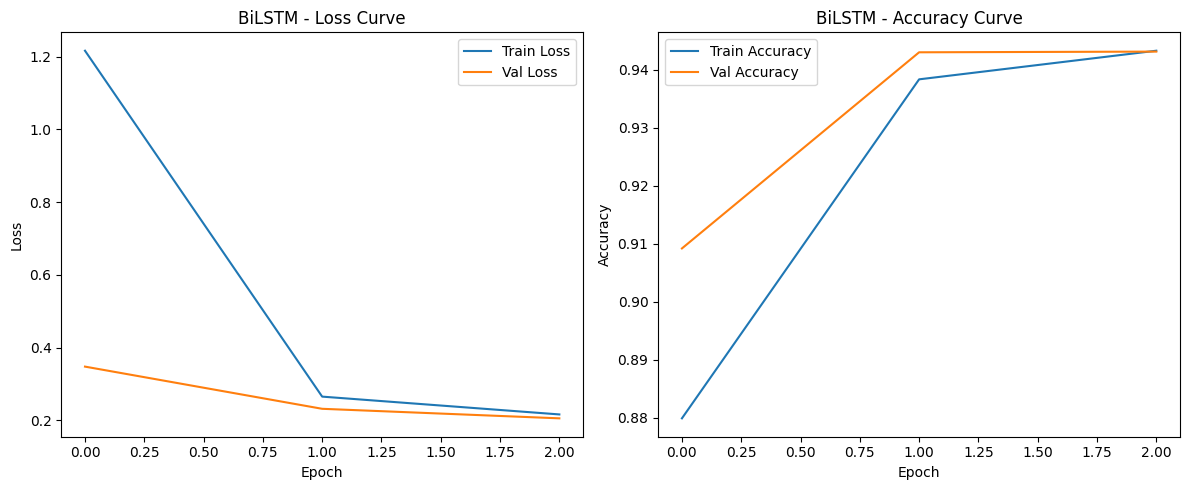

In [156]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f'{selected_model} - Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title(f'{selected_model} - Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(f"{selected_model}_training_plot.png")
plt.show()
